# ELG7186 - Winter 2022 - Assignment 3
## Due: <strong>Monday March 21<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [21]:
# Prepare your dataset here
from PIL import Image
import os
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from glob import glob
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [22]:
from keras.models import Sequential,Model
from keras.layers import Conv1D,Conv2D,MaxPool2D,Dropout,Dense,Flatten,Input,BatchNormalization
from keras.optimizers import SGD,Adam,Nadam
from keras.metrics import RootMeanSquaredError
import keras.backend as K
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.models import load_model

In [23]:
def shuffle_data(X,y): 
    p = np.random.permutation(len(X))
    return X[p],y[p]

In [24]:
def load_dataset_from_directory(dataset_dir,resize=(128,128)):
    PATH = os.path.join(dataset_dir)
    EXT = "*"

    training_img_paths=[]
    training_img_labels=[]
    for indx,(path, subdir, files) in enumerate(os.walk(PATH)):
        if indx==0:
            continue
        for file in glob(os.path.join(path, EXT)):

            im=Image.open(file)
            im= im.resize(resize)
            training_img_paths.append(np.asarray(im))
            training_img_labels.append(file.split("\\")[-2])
    return training_img_paths,training_img_labels

In [25]:
X_train,y_train = load_dataset_from_directory("training")
X_test,y_test = load_dataset_from_directory("testing")

In [26]:
X_train=np.array(X_train)
X_test=np.array(X_test)


y_train=np.array(y_train)
y_test=np.array(y_test)

In [27]:
X_train,y_train=shuffle_data(X_train,y_train)

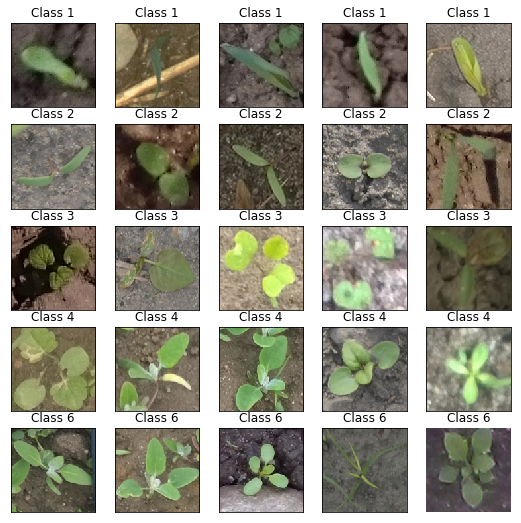

In [28]:
num_choices = 5
num_classes = np.unique(y_train)
size=9


f, axs = plt.subplots(len(num_classes), num_choices,figsize=(40,20))

for enum_indx,i in enumerate(num_classes):

    indx = np.where(y_train==i)[0]
    pick = indx[np.random.choice(indx.shape[0],num_choices)]
    for j,img_indx in zip(range(num_choices),pick):
        axs[enum_indx,j].imshow(X_train[img_indx])
        axs[enum_indx,j].figure.set_size_inches(size, size)
        axs[enum_indx,j].set_title(f"Class {i}")
        axs[enum_indx,j].set_xticks([])
        axs[enum_indx,j].set_yticks([])
        
plt.axis("off")
plt.show()

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [30]:
# Write your code here

VGG_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    classes=len(num_classes)
)

In [31]:
for i, layer in enumerate(VGG_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [32]:
for i, layer in enumerate(VGG_model.layers[:7]):
    layer.trainable=False
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False


In [33]:
x = VGG_model.layers[6].output
print(x.shape)
x= Conv2D(64, 3, padding="same",activation='relu',name="block3_conv2")(x)
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(1024, activation='relu')(x)
x = Dense(len(num_classes), activation='softmax')(x) # Softmax for multiclass
transfer_model1 = Model(inputs=VGG_model.input, outputs=x)

(None, 32, 32, 128)


In [34]:
for i, layer in enumerate(transfer_model1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv2 True
8 flatten_2 True
9 dense_3 True
10 dense_4 True


In [35]:
transfer_model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [36]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="checkpoints/model_ckpt_part1.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

In [37]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto"
)

In [39]:
transfer_model1.compile(Adam(learning_rate=1e-5), "sparse_categorical_crossentropy",metrics=["accuracy"])

In [40]:
# step 1
history = transfer_model1.fit(X_train,y_train_encoded,epochs=100,
                              validation_split=0.2,
                              shuffle=True,callbacks=[reduce_lr])

Train on 720 samples, validate on 180 samples
Epoch 1/100
720/720 [==============================] - 2s 3ms/step - loss: 584.1732 - accuracy: 0.2472 - val_loss: 454.1054 - val_accuracy: 0.2667
Epoch 2/100
720/720 [==============================] - 1s 2ms/step - loss: 141.1118 - accuracy: 0.5722 - val_loss: 330.4318 - val_accuracy: 0.2667
Epoch 3/100
720/720 [==============================] - 1s 2ms/step - loss: 75.6604 - accuracy: 0.7181 - val_loss: 427.0252 - val_accuracy: 0.2278
Epoch 4/100
720/720 [==============================] - 1s 2ms/step - loss: 19.8660 - accuracy: 0.8778 - val_loss: 355.0296 - val_accuracy: 0.3333
Epoch 5/100
720/720 [==============================] - 1s 2ms/step - loss: 6.0274 - accuracy: 0.9514 - val_loss: 325.3872 - val_accuracy: 0.3500
Epoch 6/100
720/720 [==============================] - 1s 2ms/step - loss: 2.7939 - accuracy: 0.9722 - val_loss: 308.2439 - val_accuracy: 0.3333
Epoch 7/100
720/720 [==============================] - 1s 2ms/step - loss: 2.4

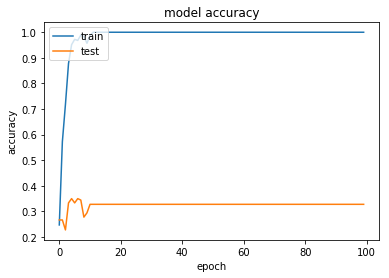

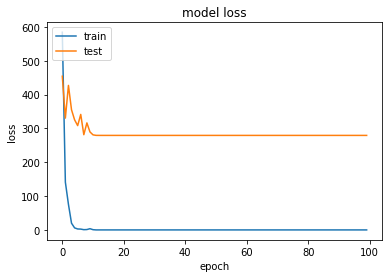

In [41]:
#Plot a loss curve for training and test data
#Plot an accuracy curve for training and test data

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()



In [42]:
np.argmax(transfer_model1.predict(X_train),axis=1)

array([4, 4, 4, 4, 2, 0, 3, 1, 3, 2, 0, 1, 4, 4, 3, 4, 4, 4, 2, 4, 0, 4,
       2, 3, 3, 2, 2, 2, 1, 1, 3, 1, 0, 0, 3, 2, 0, 4, 4, 2, 3, 2, 0, 3,
       4, 4, 1, 3, 2, 4, 3, 1, 4, 0, 1, 2, 3, 0, 2, 2, 2, 3, 0, 1, 0, 4,
       3, 3, 2, 4, 0, 4, 0, 1, 2, 3, 1, 3, 4, 0, 0, 3, 4, 0, 0, 0, 0, 4,
       4, 1, 1, 2, 1, 3, 0, 2, 1, 3, 2, 4, 1, 1, 2, 4, 2, 0, 1, 0, 1, 3,
       1, 1, 2, 3, 2, 3, 1, 4, 0, 2, 3, 0, 0, 3, 4, 4, 4, 0, 1, 1, 2, 3,
       0, 1, 1, 3, 2, 4, 4, 3, 2, 1, 3, 2, 0, 2, 3, 0, 3, 2, 1, 3, 1, 4,
       3, 1, 4, 1, 0, 0, 3, 0, 4, 3, 4, 1, 0, 3, 3, 2, 2, 1, 3, 4, 3, 2,
       4, 0, 0, 0, 3, 1, 4, 3, 3, 3, 1, 0, 1, 1, 0, 4, 2, 2, 2, 2, 4, 3,
       0, 1, 4, 1, 3, 1, 0, 3, 1, 1, 3, 2, 1, 1, 0, 4, 2, 3, 3, 2, 3, 4,
       0, 2, 3, 4, 0, 3, 0, 2, 2, 0, 4, 3, 4, 1, 1, 3, 1, 4, 3, 1, 0, 0,
       2, 3, 4, 0, 1, 3, 0, 2, 3, 0, 4, 4, 0, 4, 0, 0, 2, 4, 1, 2, 3, 3,
       3, 1, 1, 0, 4, 3, 2, 1, 4, 3, 1, 2, 1, 2, 0, 0, 4, 0, 4, 4, 0, 2,
       1, 0, 1, 3, 4, 0, 0, 2, 3, 0, 4, 0, 3, 0, 2,

In [43]:
#Provide confusion matrix of your network on the training including validation and testing data sets.
print("Training data confusion Matrix\n", confusion_matrix(y_train_encoded,np.argmax(transfer_model1.predict(X_train),axis=1)))
print("Testing data confusion Matrix\n", confusion_matrix(y_test_encoded,np.argmax(transfer_model1.predict(X_test),axis=1)))

Training data confusion Matrix
 [[159   5   7   5   4]
 [  7 158   4   9   2]
 [  7   7 157   4   5]
 [  9   6   9 152   4]
 [  4   4   9  10 153]]
Testing data confusion Matrix
 [[8 3 3 3 3]
 [5 8 3 3 1]
 [7 3 3 5 2]
 [3 5 6 5 1]
 [2 3 2 9 4]]


## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [44]:
#Write your code here

In [45]:
VGG_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    classes=len(num_classes)
)

In [46]:
for i, layer in enumerate(VGG_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [47]:
for i, layer in enumerate(VGG_model.layers[:7]):
    layer.trainable=False
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False


In [48]:
x = VGG_model.layers[6].output
print(x.shape)
x= Conv2D(64, 3, padding="same",activation='relu',name="block3_conv2")(x)
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='linear')(x) # Softmax for multiclass
transfer_model1 = Model(inputs=VGG_model.input, outputs=x)

(None, 32, 32, 128)


In [51]:
transfer_model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [52]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="checkpoints/model_ckpt_part2.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

In [53]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto"
)

In [54]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [55]:
#transfer_model1.compile(Adam(learning_rate=1e-7),loss = "mse" )
transfer_model1.compile(optimizer = "adam", loss = "mse", metrics =[root_mean_squared_error,"accuracy"])

In [56]:
# step 1
history = transfer_model1.fit(X_train,y_train_encoded,epochs=50,
                              validation_split=0.2,
                              shuffle=True,callbacks=[reduce_lr])

Train on 720 samples, validate on 180 samples
Epoch 1/50
720/720 [==============================] - 1s 2ms/step - loss: 4722396412.9340 - root_mean_squared_error: 15981.1885 - accuracy: 0.0000e+00 - val_loss: 930.6047 - val_root_mean_squared_error: 28.1285 - val_accuracy: 0.0000e+00
Epoch 2/50
720/720 [==============================] - 1s 2ms/step - loss: 284.6604 - root_mean_squared_error: 14.1774 - accuracy: 0.0056 - val_loss: 98.7436 - val_root_mean_squared_error: 8.1642 - val_accuracy: 0.0278
Epoch 3/50
720/720 [==============================] - 1s 2ms/step - loss: 82.1201 - root_mean_squared_error: 7.4759 - accuracy: 0.0361 - val_loss: 72.4567 - val_root_mean_squared_error: 6.8084 - val_accuracy: 0.0500
Epoch 4/50
720/720 [==============================] - 1s 2ms/step - loss: 69.2636 - root_mean_squared_error: 6.7887 - accuracy: 0.0375 - val_loss: 67.6526 - val_root_mean_squared_error: 6.5344 - val_accuracy: 0.0500
Epoch 5/50
720/720 [==============================] - 1s 2ms/step 

In [57]:
y_test_pred = np.clip(np.around(transfer_model1.predict(X_train)),0,5).astype(np.int8)

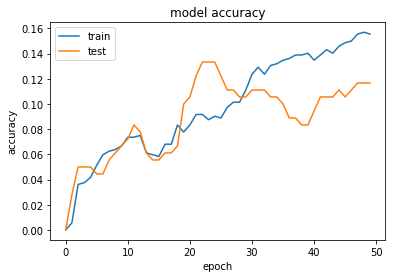

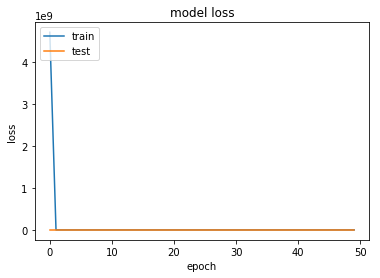

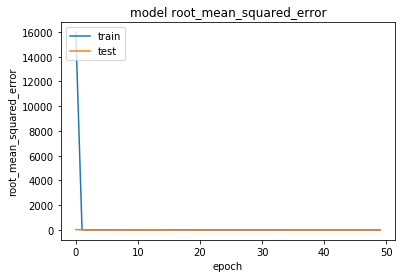

In [58]:
#Plot a loss curve for training and test data
#Plot an accuracy curve for training and test data

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()


plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
#plt.plot(history.history['val_loss'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()



In [59]:
#Provide confusion matrix of your network on the training including validation and testing data sets.
print("Training data confusion Matrix\n", confusion_matrix(y_train_encoded,np.argmax(transfer_model1.predict(X_train),axis=1)))
print("Testing data confusion Matrix\n", confusion_matrix(y_test_encoded,np.argmax(transfer_model1.predict(X_test),axis=1)))

Training data confusion Matrix
 [[180   0   0   0   0]
 [180   0   0   0   0]
 [180   0   0   0   0]
 [180   0   0   0   0]
 [180   0   0   0   0]]
Testing data confusion Matrix
 [[20  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]


Write your discussion here.

In [ ]:
############################################## Discussion ######################################################################

# The size of the data is quite small and we can see that there is an obvious overfitting in part 1a, 
# while in part 1b the model couldn't learn well but the accuracy is gap is small and the increase rate is quite the same so it's only the issue of the reformulation method itself
# by treating a classifcation problem as regression one.

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

In [60]:
# Write your code here
from keras.preprocessing.image import ImageDataGenerator


In [65]:
# Write your code here
VGG_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    classes=len(num_classes)
)

In [66]:
for i, layer in enumerate(VGG_model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [67]:
for i, layer in enumerate(VGG_model.layers[:7]):
    layer.trainable=False
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False


In [68]:
def initialize_model_part3():
    x = VGG_model.layers[6].output
    print(x.shape)
    x = Dropout(0.2)(x) 
    x= Conv2D(64, 3, activation='relu',name="block3_conv1")(x)
    x= BatchNormalization()(x)
    x = Flatten()(x) # Flatten dimensions to for use in FC layers
    x = Dropout(0.5)(x) 
    x = Dense(1024, activation='relu')(x)
    
    x = Dense(len(num_classes), activation='softmax')(x) # Softmax for multiclass
    transfer_model1 = Model(inputs=VGG_model.input, outputs=x)
    return transfer_model1

In [71]:
transfer_model1=initialize_model_part3()

(None, 32, 32, 128)


In [72]:
for i, layer in enumerate(transfer_model1.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 dropout_1 True
8 block3_conv1 True
9 batch_normalization_1 True
10 flatten_4 True
11 dropout_2 True
12 dense_7 True
13 dense_8 True


In [73]:
transfer_model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [74]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="checkpoints/model_ckpt_part3_step1.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

In [75]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto"
)

In [77]:
#transfer_model1=load_model("checkpoints/model_ckpt_part3_step1.h5")

In [78]:
transfer_model1.compile(Adam(learning_rate=1e-3), "sparse_categorical_crossentropy",metrics=["accuracy"])# 4 9

In [79]:
# step 1
history = transfer_model1.fit(X_train,y_train_encoded,epochs=100,
                              validation_split=0.2,
                              shuffle=True,callbacks=[reduce_lr])

Train on 720 samples, validate on 180 samples
Epoch 1/100
720/720 [==============================] - 2s 2ms/step - loss: 7.7640 - accuracy: 0.2681 - val_loss: 27.2090 - val_accuracy: 0.2611
Epoch 2/100
720/720 [==============================] - 1s 2ms/step - loss: 0.8214 - accuracy: 0.7847 - val_loss: 8.4332 - val_accuracy: 0.3278
Epoch 3/100
720/720 [==============================] - 1s 2ms/step - loss: 0.3277 - accuracy: 0.9042 - val_loss: 3.3233 - val_accuracy: 0.3667
Epoch 4/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1359 - accuracy: 0.9694 - val_loss: 1.9881 - val_accuracy: 0.4556
Epoch 5/100
720/720 [==============================] - 1s 2ms/step - loss: 0.0583 - accuracy: 0.9903 - val_loss: 2.5833 - val_accuracy: 0.4389
Epoch 6/100
720/720 [==============================] - 1s 2ms/step - loss: 0.0358 - accuracy: 0.9931 - val_loss: 2.3510 - val_accuracy: 0.4611
Epoch 7/100
720/720 [==============================] - 1s 2ms/step - loss: 0.0986 - accuracy: 0

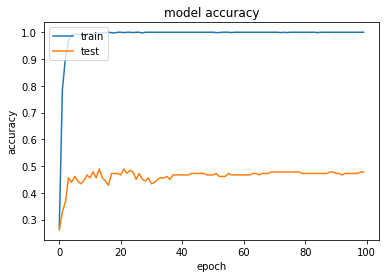

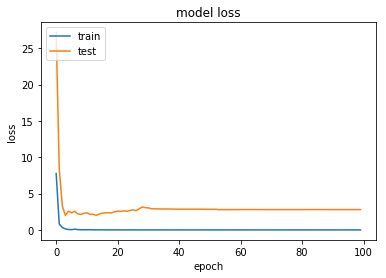

In [80]:
#Plot a loss curve for training and test data
#Plot an accuracy curve for training and test data

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()



In [81]:
#Provide confusion matrix of your network on the training including validation and testing data sets.
print("Training data confusion Matrix\n", confusion_matrix(y_train_encoded,np.argmax(transfer_model1.predict(X_train),axis=1)))
print("Testing data confusion Matrix\n", confusion_matrix(y_test_encoded,np.argmax(transfer_model1.predict(X_test),axis=1)))

Training data confusion Matrix
 [[168   4   7   0   1]
 [  5 162   7   4   2]
 [  4   6 158   4   8]
 [  4   6   7 152  11]
 [  4   0   9   1 166]]
Testing data confusion Matrix
 [[13  0  6  0  1]
 [ 6  8  5  1  0]
 [ 2  3  8  5  2]
 [ 1  2  4  4  9]
 [ 0  2  3  3 12]]


In [110]:
# step 2
transfer_model1=initialize_model_part3()

(None, 32, 32, 128)


In [111]:
X_train_part3,X_valid_part3,y_train_part3_encoded,y_valid_part3_encoded = train_test_split(X_train,y_train_encoded,test_size=0.2,shuffle=True,stratify=y_train_encoded)
len(X_train_part3)

720

In [112]:
dataGen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.1, zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True, vertical_flip=True, rescale=0.1
)

In [114]:
dataGen_for_train=dataGen.flow(X_train_part3,y_train_part3_encoded,shuffle=False,seed=0,batch_size=64)
dataGen_for_valid=dataGen.flow(X_valid_part3,y_valid_part3_encoded,shuffle=True,seed=0,batch_size=64)

In [115]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="checkpoints/model_ckpt_part3_step2.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)

In [116]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto"
)

In [117]:
#transfer_model1=load_model("checkpoints/model_ckpt_part3_step2.h5") #130+200

In [118]:
#transfer_model1.compile(Adam(learning_rate=1e-8), "sparse_categorical_crossentropy",metrics=["accuracy"])
transfer_model1.compile(Adam(learning_rate=1e-4), "sparse_categorical_crossentropy",metrics=["accuracy"])
 

In [119]:
# step 2
history = transfer_model1.fit(dataGen_for_train,epochs=200,
                              validation_data=dataGen_for_valid,
                              shuffle=True,callbacks=[reduce_lr])

Epoch 1/200
12/12 [==============================] - 2s 161ms/step - loss: 2.5704 - accuracy: 0.2444 - val_loss: 17.2850 - val_accuracy: 0.2111
Epoch 2/200
12/12 [==============================] - 1s 109ms/step - loss: 2.5929 - accuracy: 0.3236 - val_loss: 5.5427 - val_accuracy: 0.2944
Epoch 3/200
12/12 [==============================] - 1s 119ms/step - loss: 2.3636 - accuracy: 0.3514 - val_loss: 4.6122 - val_accuracy: 0.3444
Epoch 4/200
12/12 [==============================] - 1s 116ms/step - loss: 2.1857 - accuracy: 0.3792 - val_loss: 3.3999 - val_accuracy: 0.3556
Epoch 5/200
12/12 [==============================] - 1s 117ms/step - loss: 2.2379 - accuracy: 0.3861 - val_loss: 2.9982 - val_accuracy: 0.3389
Epoch 6/200
12/12 [==============================] - 1s 120ms/step - loss: 2.2082 - accuracy: 0.3361 - val_loss: 2.3420 - val_accuracy: 0.3389
Epoch 7/200
12/12 [==============================] - 1s 114ms/step - loss: 2.0659 - accuracy: 0.3917 - val_loss: 2.4492 - val_accuracy: 0.383

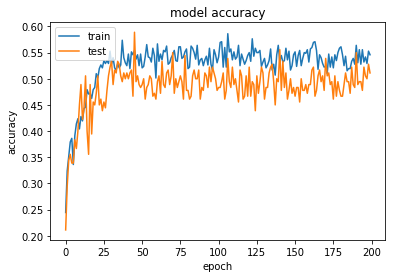

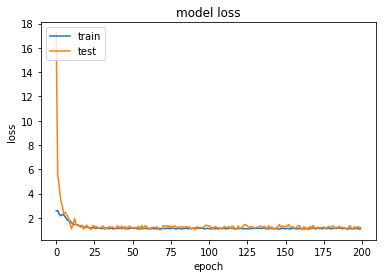

In [120]:
#Plot a loss curve for training and test data
#Plot an accuracy curve for training and test data

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train',"test"], loc='upper left')
plt.show()



In [121]:
#Provide confusion matrix of your network on the training including validation and testing data sets.
print("Training data confusion Matrix\n", confusion_matrix(y_train_encoded,np.argmax(transfer_model1.predict(X_train),axis=1)))
print("Testing data confusion Matrix\n", confusion_matrix(y_test_encoded,np.argmax(transfer_model1.predict(X_test),axis=1)))

Training data confusion Matrix
 [[  2  50 102  25   1]
 [  0  90  50  40   0]
 [  0  31  97  47   5]
 [  0  14  60  99   7]
 [  0   1  58  83  38]]
Testing data confusion Matrix
 [[ 0  5 12  1  2]
 [ 0  8 10  2  0]
 [ 0  2  7 10  1]
 [ 0  1  7 10  2]
 [ 0  1  8  9  2]]


Write your discussion here.

In [ ]:
############################################## Discussion ######################################################################


# Without data augmentation the models seems to overfit, although we have Batch_normalization and dropout but it still over fit and very rapidly as well in the first 10 20 epochs,
# while on the other hand, by adding data augmentation to it , the accuracy seems to increase together with no huge gap as we saw before, the problem maybe that the model needs 
# to be much deeper than that and have more Convolutional layers or more data to have more variations and wide distribution to learn easily from.

# So we can say there is much better improvement in general comapred to the step without data augmentation.

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.